In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sber_data = pd.read_csv('data/sber_data.csv', sep=',')
# Находим средний процент по столбцам
cols_null_precent = sber_data.isnull().mean() * 100
# Сортируем по убыванию
cols_with_null = cols_null_precent[cols_null_precent>0].sort_values(ascending=False)

## Метод ручного поиска и здравого смысла
Рассчитаем статистические показатели для признака жилой площади (life_sq) с помощью метода describe()

In [2]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [3]:
# Найдем число квартир с 0 площадью
print(sber_data[sber_data['life_sq'] == 0].shape[0])

45


In [4]:
# Теперь выведем здания с площадью более 7000
display(sber_data[sber_data['life_sq'] > 7000])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


In [3]:
# Возникает вопрос: много ли таких квартир, где жилая площадь
# превышает суммарную, проверим с помощью фильтрации:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


In [4]:
# Данные наблюдения ошибочны, поэтому избавимся от них с помощью drop()
# удалив записи по индексам
cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результат: {cleaned.shape[0]}')

Результат: 30434


In [7]:
# Теперь рассмотрим признак этажей
display(sber_data['floor'].describe())

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

In [ ]:
# Есть сомнительная квартира на 77 этаже, проверим все
# которые находятся выше 50 этажей
display(sber_data[sber_data['floor'] > 50])

# Убедившись в интернете, что в данном районе нет зданий 
# выше 50 этажей делаем вывод, что это выброс

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


## Метод межквантильного размаха (метод Тьюки)
Отличным помощником в поиске потенциальных выбросов является визуализация. Если признак является числовым, то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.

Text(0.5, 1.0, 'Full Square Boxplot')

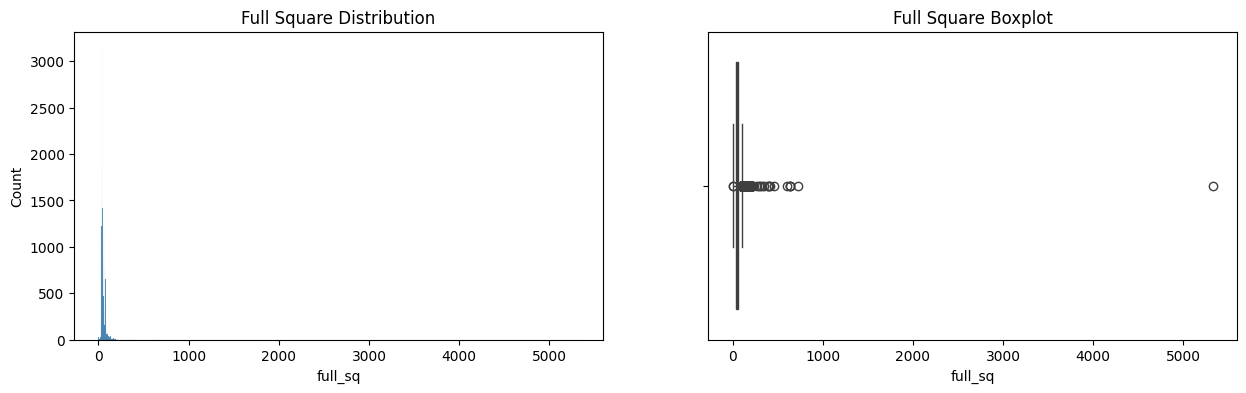

In [11]:
# Построим гистограмму и коробчатую диаграмму
# для признака полной площади

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0])
histplot.set_title('Full Square Distribution')
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1])
boxplot.set_title('Full Square Boxplot')

Визуализация помогает определить наличие выбросов. Для того чтобы их найти, можно воспользоваться статистическими подходами. 

Одним из таких подходов является метод межквартильного размаха (его еще называют методом Тьюки), который используется для построения коробчатой диаграммы.

Алгоритм метода:
- вычислить 25-ый и 75-ый квантили (первый и третий квартили) — Q25 и Q75 для признака, который мы исследуем;
- Вычислить межквантильное расстояние: IQR = Q75 - Q25
- Вычислить верхнюю и нижнюю границы Тьюки:
    - bound lower = Q25 - 1.5xIQR
    - bound upper = Q75 + 1.5xIQR
- Найти наблюдения, которые выходят за пределы границ
В соответствии с этим алгоритмом напишем функцию outliers_iqr(), которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.

Квантили вычисляются с помощью метода quantile(). Потенциальные выбросы определяются при помощи фильтрации данных по условию выхода за пределы верхней или нижней границы.

In [5]:
def outliers_iqr(data, feature, left=1, right=6):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [6]:
# Применим эту функцию к sber_data и признаку full_sq
# а также выведем размерности результатов
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по Тьюки: {outliers.shape[0]}')
print(f'Результатирующее число записей: {cleaned.shape[0]}')

Число выбросов по Тьюки: 59
Результатирующее число записей: 30412


Text(0.5, 1.0, 'Cleaned Full Square Boxplot')

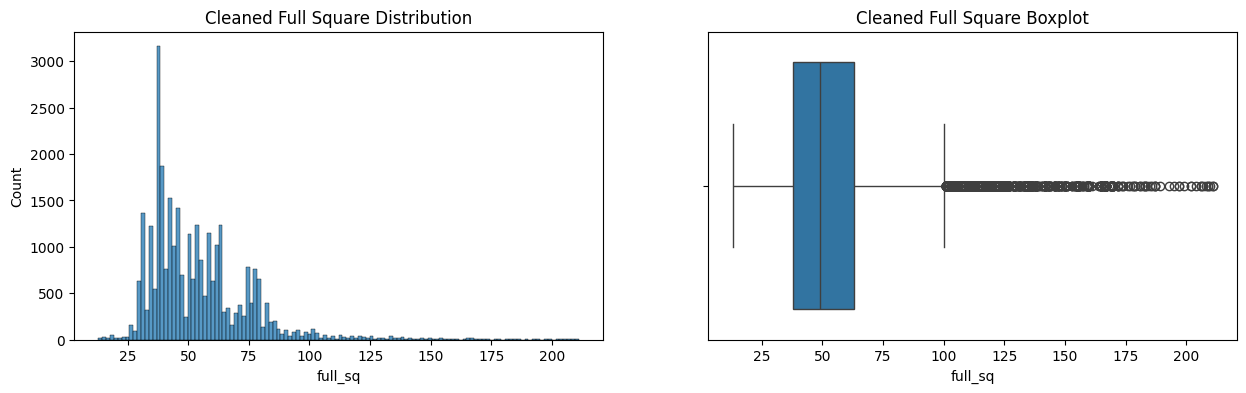

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot')

In [8]:
def outliers_iqr_mod(data, feature, left=1, right=6):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [9]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq', left=1, right=6)
print(f'Число выбросов по Тьюки: {outliers.shape[0]}')
print(f'Результатирующее число записей: {cleaned.shape[0]}')

Число выбросов по Тьюки: 59
Результатирующее число записей: 30412


Text(0.5, 1.0, 'Cleaned Full Square Boxplot')

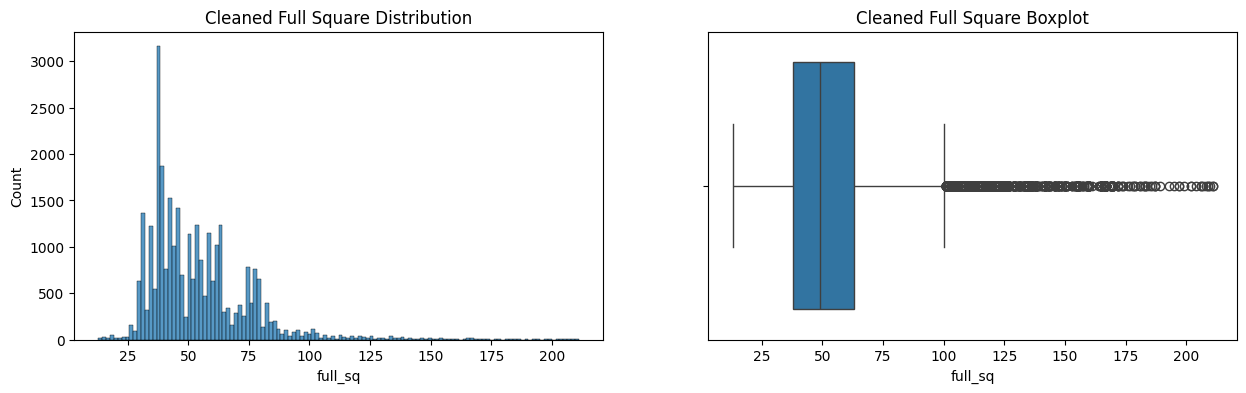

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot')

## Метод Z-отклонений (метод сигм)
Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от (мю - 3сигма, мю+3сигма), где (мю) — математическое ожидание (для выборки это среднее значение), а (сигма) — стандартное отклонение. Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.
Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от , где   (мю) — математическое ожидание (для выборки это среднее значение), а  (сигма) — стандартное отклонение. Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.
Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.

Text(0.5, 1.0, 'Log MKAD Km Distruction')

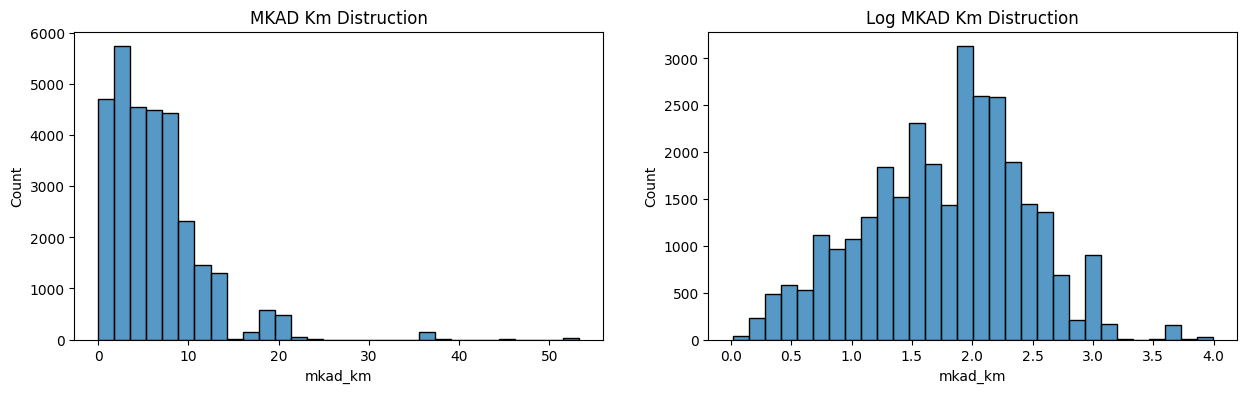

In [13]:
fix, axes = plt.subplots(1, 2, figsize=(15,4))

# Гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distruction')

# Гистограмма в логарифмическом масштабе
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distruction')

In [14]:
# Численный показатель асиметрии можно вычислить с помощью метода skew():
print(log_mkad_km.skew())

-0.14263612203024953


Напишем функцию outliers_z_score()
На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

In [15]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x= np.log(data[feature] + 1)
    else:
        x= data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[( x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [18]:
# Применим функцию к таблице sber_data и признаку mkad_km, а так же выведем размерности результатов
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу Z-отклонения: {outliers.shape[0]}')
print(f'Результатирующее число записей:{cleaned.shape[0]}')

Число выбросов по методу Z-отклонения: 33
Результатирующее число записей:30438


In [19]:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


 Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала . Вертикальные линии можно построить с помощью метода axvline(). Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

Text(0.5, 1.0, 'Log MKAD Km Distribution')

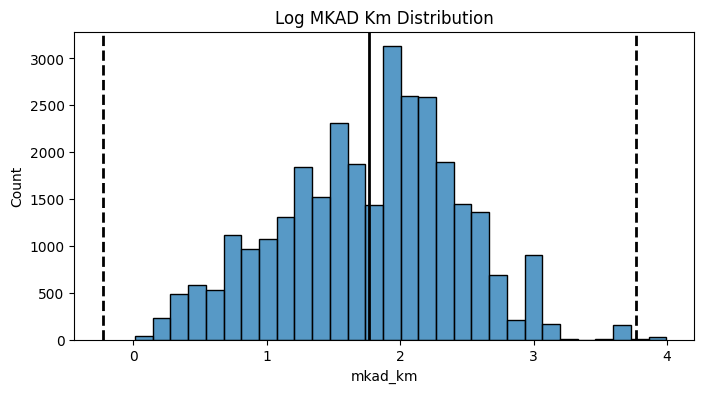

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean() + 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean() - 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution')

In [24]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x= np.log(data[feature] + 1)
    else:
        x= data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[( x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [25]:
outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', left=3, right=3.5, log_scale=True)
print(f'Число выбросов по методу Z-отклонения: {outliers.shape[0]}')
print(f'Результатирующее число записей:{cleaned.shape[0]}')

Число выбросов по методу Z-отклонения: 0
Результатирующее число записей:30471


## Резюме по методам выбросов:
Мы рассмотрели классические методы выявления аномальных данных. Как вы сами поняли, каждый из них имеет свои преимущества и недостатки.

Метод ручного поиска тяжело автоматизировать, однако вы сами организовываете проверки, следите за процессом отсеивания выбросов и руководствуетесь не только статистикой, но и здравым смыслом. К тому же из всех представленных только этот метод способен выявить логические нестыковки в данных (например, общая площадь меньше жилой или число этажей более 77 в районе, где нет таких зданий). Обычно этот метод используется в комплексе с другими, чтобы удостовериться в том, что найденные данные действительно являются выбросами, и произвести логическую очистку, на которую неспособны другие методы.

Методы межквартильного размаха и z-отклонений довольно просты в реализации и основаны на стройной математической теории, а не на эвристиках. Но это их преимущество и недостаток. Оба метода разработаны для данных, распределённых приблизительно нормально. Проблема в том, что далеко не всё в мире имеет нормальное распределение. Необходимо внимательно «рыться» в данных, совершать дополнительные преобразования, чтобы привести их хотя бы к подобию нормального распределения, либо подбирать границы методов, чтобы учитывать особенности распределений. В противном случае методы начинают считать выбросами всё, что не вписывается в жёсткие границы, и вы рискуете лишиться важных данных! Учитывайте это в своей работе и всегда проверяйте результаты.

Text(0.5, 1.0, 'Price doc log')

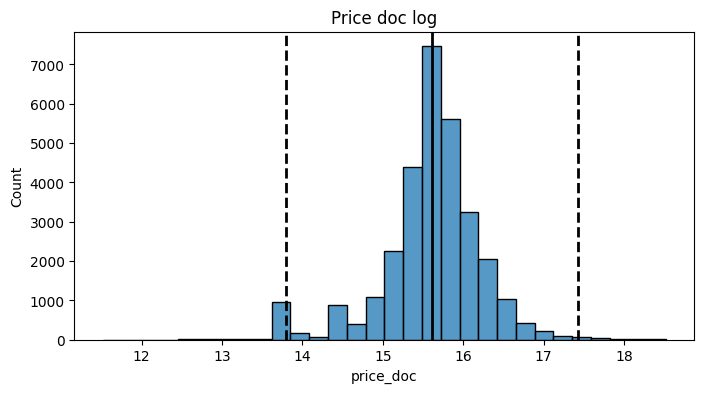

In [27]:
# 6.5 Постройте гистограмму для признака price_doc в логарифмическом масштабе. А также, добавьте на график линии, 
# отображающие среднее и границы интервала для метода трех сигм
fig, ax = plt.subplots(1, 1, figsize=(8,4))
price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(price_doc, bins=30, ax=ax)
histplot.axvline(price_doc.mean(), color='k', lw=2)
histplot.axvline(price_doc.mean() + 3 * price_doc.std(), color='k', ls='--', lw=2)
histplot.axvline(price_doc.mean() - 3 * price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Price doc log')

In [28]:
# 6.6 Найдите потенциальные выбросы по признаку price_doc с помощью метода z-отклонения. 
# Используйте логарифмический масштаб распределения. Сделайте «послабление» на 0.7 сигм в обе стороны распределения.
# Сколько выбросов вы получили?
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', left=3.7, right=3.7, log_scale=True)
print(f'Число выбросов по методу Z-отклонения: {outliers.shape[0]}')
print(f'Результатирующее число записей:{cleaned.shape[0]}')

Число выбросов по методу Z-отклонения: 52
Результатирующее число записей:30419


In [ ]:
# Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). Добавьте в неё параметр log_scale. 
# Если он выставлен в True, то производится логарифмирование признака. Примените полученную функцию к признаку price_doc. 
# Число межквартильных размахов в обе стороны обозначьте как 3. Чему равно число выбросов, полученных таким методом?
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x= np.log(data[feature])
    else:
        x= data[feature]
    quartile1, quartile3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (iqr*left)
    upper_bound = quartile3 + (iqr*right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[( x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу Z-отклонения: {outliers.shape[0]}')
print(f'Результатирующее число записей:{cleaned.shape[0]}')

Число выбросов по методу Z-отклонения: 92
Результатирующее число записей:30379
